# Multiple Adjacency Spectral Embedding (MASE)

Multiple Adjacency Spectral Embedding (MASE) is an extension of Adjacency Spectral Embedding (see ASE [tutorial](https://graspy.neurodata.io/tutorials/embedding/adjacencyspectralembed)) for an arbitrary number of graphs.  Once graphs are embedded, the low-dimensional Euclidean representation can be used to visualize the latent positions of vertices, perform inference, etc.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Using MultipleASE with Stochastic Block Model

In order to demonstrate how to use the ``MultipleASE`` class, we will use a simple example: two 2-block stochastic block models (SBMs) with different block probabilities.  Indeed, we will use the same models as in the omnibus [tutorial](https://graspy.neurodata.io/tutorials/embedding/omnibus) to facilitate direct comparison. 

## Simulate two different graphs using stochastic block models (SBM)

We sample two 2-block SBMs (undirected, no self-loops) with 50 vertices, each block containing 25 vertices ($n = [25, 25]$), and with the following block connectivity matrices:

\begin{align*}
B_1 = 
\begin{bmatrix}0.3 & 0.1\\
0.1 & 0.7
\end{bmatrix},~
B_2 = \begin{bmatrix}0.3 & 0.1\\
0.1 & 0.3
\end{bmatrix}
\end{align*}

The only difference between the two is the within-block probability for the second block. We sample $G_1 \sim \text{SBM}(n, B_1)$ and $G_2 \sim \text{SBM}(n, B_2)$.

In [36]:
from graspologic.simulations import sbm

n = [25, 25]
B1 = [[0.3, 0.1],
      [0.1, 0.7]]
B2 = [[0.3, 0.1],
      [0.1, 0.3]]

np.random.seed(8)
G1 = sbm(n, P1)
G2 = sbm(n, P2)

## Visualize the graphs using heatmap

We visualize the sampled graphs using the ``heatmap()`` function. ``heatmap()`` will plot the adjacency matrix, where the colors represent the weight of each edge. In this case, we have binary graphs so the values will be either 0 or 1. 

We see that there is clear block structure to the graphs. Furthermore, the lower right quarter of $G_1$, representing the within-group connections for the second group, is more dense than that of $G_2$.

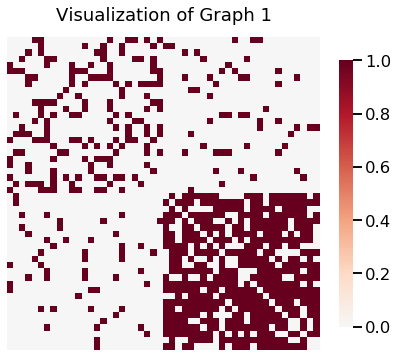

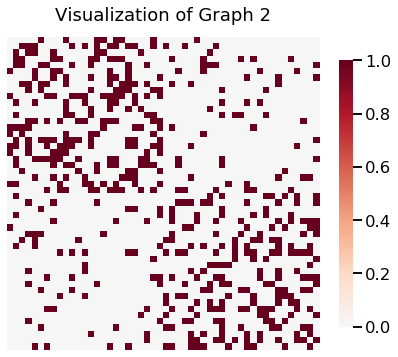

In [37]:
from graspologic.plot import heatmap

heatmap(G1, figsize=(7,7), title="Visualization of Graph 1")
heatmap(G2, figsize=(7,7), title="Visualization of Graph 2");

## Embed the two graphs using MASE

Just as ASE fits a single input graph to the Random Dot Product Graph (RDPG) model, MASE fits a sample of graphs to the common subspace independent-edge (COSIE) model, which is an extension of the RDPG model to multiple graphs. The COSIE model assumes that all of the graphs have important shared properties, but also meaningful differences.  As a result, each vertex has a single position in the common subspace that is invariant across all of the graphs, represented by $V\in \mathbb{R}^{n\times d}$ (where $n$ is the number of vertices and $d$ is the embedding dimension).  But, each graph $A^{(i)}$ has a potentially different score matrix $R^{(i)} \in \mathbb{R}^{d \times d}$, allowing the actual connection probabilities between each vertex to vary from one graph to the next.  With this structure, COSIE facilitates comparison due to the common subspace, while retaining sufficient flexibility to represent heterogeneous collections of graphs, due to the different score matrices.

Since we know that, in general, 2 clusters are faithfully represented in 2 dimensions, we specify the number of components as 2. Then, the ``fit_transform()`` method returns the estimated common subspace positions $\hat{V}$, which we can see has 50 entries corresponding to the 50 vertices embedded in 2 dimensions.

In [38]:
from graspologic.embed import MultipleASE as MASE

embedder = MASE(n_components=2)
V_hat = embedder.fit_transform([G1, G2])
print(V_hat.shape)

(50, 2)


## Visualize Common Latent Subspace

Since the two graphs have clear block structures, with higher within-block probabilities than between-block, we see two distinct "clusters" when we visualize the latent subspace positions.

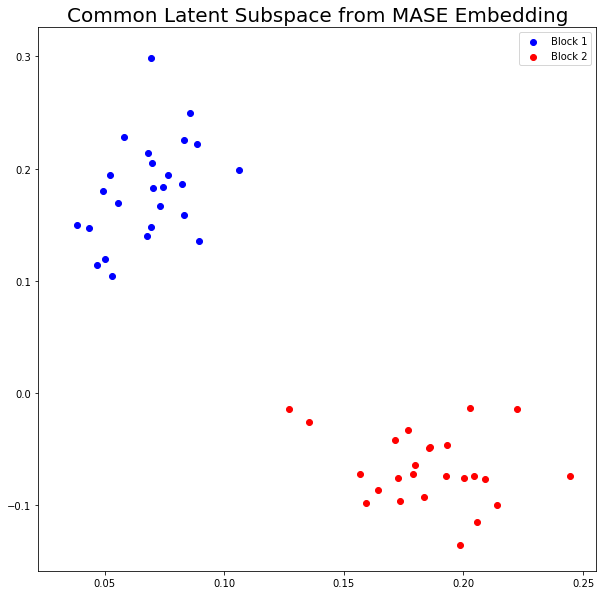

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(V_hat[:25, 0], V_hat[:25, 1], c="blue", label="Block 1")
ax.scatter(V_hat[25:, 0], V_hat[25:, 1], c="red", label="Block 2")
ax.legend()
ax.set_title("Common Latent Subspace from MASE Embedding", fontsize=20);

## Recover Probability Matrices

Since ``MultipleASE()`` stores estimates of the individual score matrices $\hat{R}^{(i)}$ as well as an estimate of the common invariant subspace $\hat{V}$, we can recover an estimate of the probability matrix for each graph 
$$\hat{P}^{(i)} = V R^{(i)} V^T$$

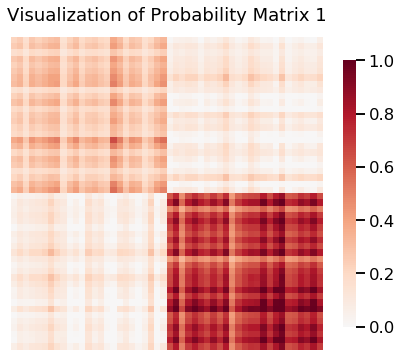

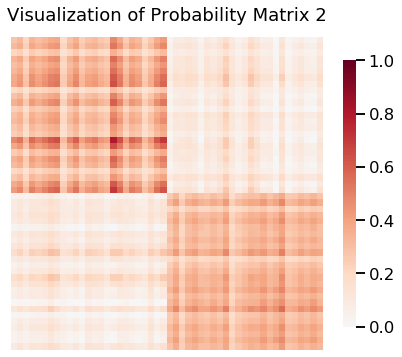

In [41]:
R = embedder.scores_
R_1 = R[0]
R_2 = R[1]

V_hat_T = np.transpose(V_hat)
P_1_hat = np.matmul(np.matmul(V_hat, R_1), V_hat_T)
P_2_hat = np.matmul(np.matmul(V_hat, R_2), V_hat_T)

P1_hat_vis = heatmap(P_1_hat, figsize=(7,7), title="Visualization of Probability Matrix 1", vmin=0, vmax=1)
P2_hat_vis = heatmap(P_2_hat, figsize=(7,7), title="Visualization of Probability Matrix 2", vmin=0, vmax=1)

## Recover Original Block Connectivity Matrices

Now, we can see the clear block structure once again.  In order to obtain an estmate of the original block connectivity matrices, we can average across the blocks.

In [42]:
B1_hat = np.array([[np.mean(P_1_hat[:25, :25]), np.mean(P_1_hat[:25, 25:])],
               [np.mean(P_1_hat[25:, :25]), np.mean(P_1_hat[25:, 25:])]])
B2_hat = np.array([[np.mean(P_2_hat[:25, :25]), np.mean(P_2_hat[:25, 25:])],
               [np.mean(P_2_hat[25:, :25]), np.mean(P_2_hat[25:, 25:])]])
print("B1_hat =\n", B1_hat)
print("B2_hat =\n", B2_hat)

B1_hat =
 [[0.26973154 0.08100194]
 [0.08100194 0.72789101]]
B2_hat =
 [[0.34302685 0.09781598]
 [0.09781598 0.32270201]]


 Although we don't get exactly the same block probabilities as we input into the SBM, it's fairly close with only one 50-vertex graph for each!

## Sampling More Graphs

We can recover an even more accurate representation of the two SBMs with more sample graphs.  Let's try with 100 graphs sampled from each.

In [43]:
G1 = [sbm(n, P1) for i in range(100)]
G2 = [sbm(n, P2) for i in range(100)]

V_hat = embedder.fit_transform(G1 + G2)

## Visualizing Common Latent Subspace

Now, the clustering is even more distinct, as we would expect with more samples.

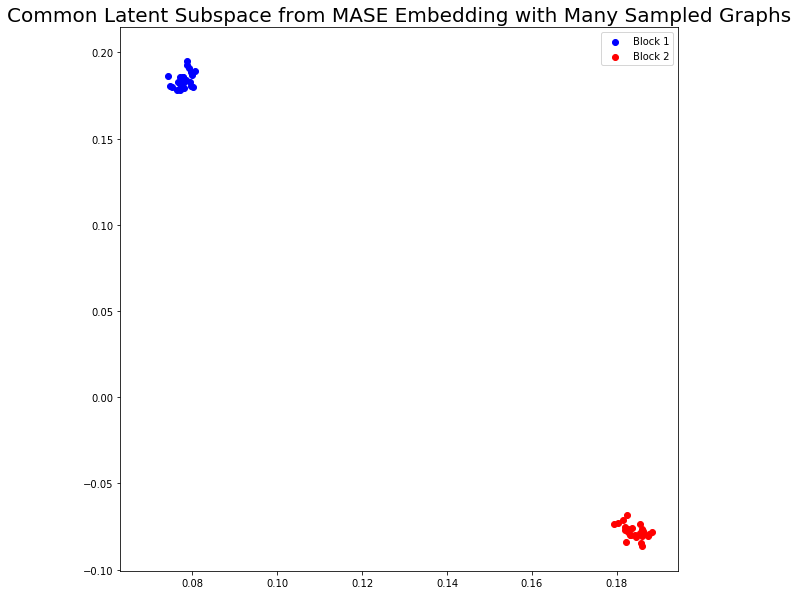

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(V_hat[:25, 0], V_hat[:25, 1], c="blue", label="Block 1")
ax.scatter(V_hat[25:, 0], V_hat[25:, 1], c="red", label="Block 2")
ax.legend()
ax.set_title("Common Latent Subspace from MASE Embedding with Many Sampled Graphs", fontsize=20);

## Recover Probability Matrices

Since we have many samples, we first obtain the estimated probability matrix $\hat{P}^{(i)} = \hat{V} \hat{R}^{(i)} \hat{V}^T$ for each graph, and then we average across all the graphs generated from the same SBM in order to recover the probabiliity matrices.

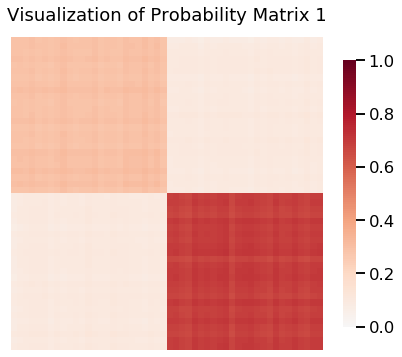

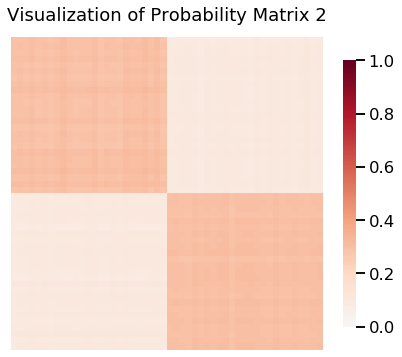

In [45]:
#Obtain list of P_hats for each graph
R = embedder.scores_
V_hat_T = np.transpose(V_hat)
P_hat = np.array([np.matmul(np.matmul(V_hat, R[i]), V_hat_T) for i in range(len(R))])

#Average across all graphs generated from the same distribution.
P1_hat = np.mean(P_hat[:100], 0)
P2_hat = np.mean(P_hat[100:], 0)

#Visualize
P1_hat_vis = heatmap(P1_hat, figsize=(7,7), title="Visualization of Probability Matrix 1", vmin=0, vmax=1)
P2_hat_vis = heatmap(P2_hat, figsize=(7,7), title="Visualization of Probability Matrix 2", vmin=0, vmax=1)

## Recover Original Block Connectivity Matrices

And we see that our estimates for the block probabilities are closer to the true values with a higher number of samples.

In [46]:
B1_hat = np.array([[np.mean(P1_hat[:25, :25]), np.mean(P1_hat[:25, 25:])],
               [np.mean(P_1_hat[25:, :25]), np.mean(P_1_hat[25:, 25:])]])
B2_hat = np.array([[np.mean(P2_hat[:25, :25]), np.mean(P2_hat[:25, 25:])],
               [np.mean(P2_hat[25:, :25]), np.mean(P2_hat[25:, 25:])]])
print("B1_hat =\n", P1_hat_block)
print("B1_hat =\n", P2_hat_block)

B1_hat =
 [[0.29444381 0.09845532]
 [0.08100194 0.72789101]]
B1_hat =
 [[0.29663565 0.10166256]
 [0.10166256 0.29960554]]
